### Sample program for c-DCGAN  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, Flatten, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
np.random.seed(17)
tf.random.set_seed(19)

2022-01-20 23:33:30.738920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 23:33:30.738958: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Parameters  

In [2]:
used_digits = [4, 8]
n_digits = len(used_digits)
digit2idx = { x:i for i,x in enumerate(used_digits) }
print(digit2idx)
digits_str = ''.join([str(x) for x in used_digits])

n_data = 1500
n_epoch = 50
n_noise = 100
batch_size = 32

img_dir = 'images_cdcgan'
model_g = 'model_cdcgan-b{}_g-d{}.h5'.format(batch_size, digits_str)
model_d = 'model_cdcgan-b{}_d-d{}.h5'.format(batch_size, digits_str)

{4: 0, 8: 1}


#### Remove old img_dir and create new one  

In [3]:
import shutil, os
if os.path.exists(img_dir):
    shutil.rmtree(img_dir)

cnt = 10
while cnt > 0:
    try:
        os.makedirs(img_dir)
        break
    except:
        sleep(1)
    cnt -= 1
    
if cnt <= 0:
    print('Cannot mkdir:', img_dir)
else:
    print('mkdir: OK')

mkdir: OK


#### Generator  

In [4]:
def generator_model():
    in1 = Input(shape=(n_noise,))
    in2 = Input(shape=(n_digits,))
    in12 = concatenate([in1, in2])
    x = Dense(256, activation='tanh')(in12)
    x = Dense(64 * 7 * 7)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Reshape((7, 7, 64), input_shape=(7 * 7 * 64,))(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same', activation='tanh',
               data_format='channels_last')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(1, (5, 5), padding='same', activation='tanh',
               data_format='channels_last')(x)
    model = Model(inputs=[in1, in2], outputs=x)
    return model

#### Discriminator  

In [5]:
def discriminator_model():
    in1 = Input(shape=(28, 28, 1))
    in2 = Input(shape=(n_digits,))
    in2_up = Reshape((1, 1, n_digits))(in2)
    in2_up = UpSampling2D((28, 28))(in2_up)
    in12 = concatenate([in1, in2_up])
    x = Conv2D(32, (5, 5), padding='same', activation='tanh',
               data_format='channels_last')(in12)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (5, 5), padding='same', activation='tanh',
               data_format='channels_last')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[in1, in2], outputs=x)
    return model

#### D(G(z))  

In [6]:
def generator_containing_discriminator(generator, discriminator):
    in1 = Input(shape=(n_noise,))
    in2 = Input(shape=(n_digits,))
    x = generator([in1, in2])
    discriminator.trainable = False
    x = discriminator([x, in2])
    model = Model(inputs=[in1, in2], outputs=x)
    return model

#### For output image samples  

In [7]:
def combine_images(generated_images):
    generated_images = generated_images.reshape(generated_images.shape[0],
                                                generated_images.shape[3],
                                                generated_images.shape[1],
                                                generated_images.shape[2])
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image

#### For output image samples with labels  

In [8]:
def combine_images_digits(generated_images, n_digits, height=None):
    generated_images = generated_images.reshape(generated_images.shape[0],
                                                generated_images.shape[3],
                                                generated_images.shape[1],
                                                generated_images.shape[2])
    if height is not None:
        generated_images = generated_images[:height*n_digits]
    else:
        height = generated_images.shape[0]
    width = n_digits
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image

#### Training (learning)  

In [9]:
def train(BATCH_SIZE):
    (X_train, y_train), (X_test, y_test) = shuffle(mnist.load_data())
    X_train = X_train[ np.isin(y_train, used_digits) ]
    y_train = y_train[ np.isin(y_train, used_digits) ]
    X_train = X_train[:n_data]
    y_train = y_train[:n_data]
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
    y_train = np.array([digit2idx[x] for x in y_train])
    y_train = to_categorical(y_train, n_digits)
    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = \
        generator_containing_discriminator(generator, discriminator)
    #d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    #g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    #generator.compile(loss="binary_crossentropy", optimizer="SGD")
    d_optim = Adam()
    g_optim = Adam()
    generator.compile(loss="binary_crossentropy", optimizer="Adam")
    discriminator_on_generator.compile(
        loss="binary_crossentropy", optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss="binary_crossentropy", optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, n_noise))
    ret = []
    for epoch in range(n_epoch):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        n_index = int(X_train.shape[0]/BATCH_SIZE)
        for index in range(n_index):
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, n_noise)
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            image_batch = image_batch.reshape(image_batch.shape[0],
                                              image_batch.shape[2],
                                              image_batch.shape[3],
                                              image_batch.shape[1])
            labels = y_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict([noise, labels], verbose=0)
            if (epoch == 0 and index == 0) or index == (n_index-1):
                image = combine_images(generated_images)
                image = image*127.5+127.5
                img_file = str(epoch)+"_"+str(index)+".png"
                img_file = os.path.join(img_dir, img_file)
                Image.fromarray(image.astype(np.uint8)).save(img_file)

            X_img = np.concatenate((image_batch, generated_images))
            X_lbl = np.concatenate((labels, labels))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = discriminator.train_on_batch([X_img, X_lbl], y)
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, n_noise)
            discriminator.trainable = False
            g_loss = discriminator_on_generator.train_on_batch(
                [noise, labels], [1] * BATCH_SIZE)
            discriminator.trainable = True
            loss_msg = "batch {:d}  d_loss: {:f}".format(index, d_loss)
            loss_msg += "  g_loss: {:f}".format(g_loss)
            print(loss_msg)
            ret.append((epoch, index, d_loss, g_loss))
            if index % 10 == 9:
                generator.save_weights("generator", True)
                discriminator.save_weights("discriminator", True)
                
    generator.save(model_g)
    discriminator.save(model_d)
    return ret

#### Do training (learning)  

In [10]:
%%time

train_log = train(BATCH_SIZE=batch_size)

Instructions for updating:
Colocations handled automatically by placer.


2022-01-20 23:33:38.395835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 23:33:38.395940: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 23:33:38.395977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist


Epoch is 0
Number of batches 46


2022-01-20 23:33:39.109224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-20 23:33:41.278319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32614400 exceeds 10% of free system memory.


batch 0  d_loss: 0.748881  g_loss: 1.145698


2022-01-20 23:33:41.668286: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32614400 exceeds 10% of free system memory.


batch 1  d_loss: 0.177903  g_loss: 5.427390


2022-01-20 23:33:42.006191: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32614400 exceeds 10% of free system memory.


batch 2  d_loss: 0.006019  g_loss: 8.828770


2022-01-20 23:33:42.316667: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32614400 exceeds 10% of free system memory.


batch 3  d_loss: 0.043294  g_loss: 11.825085


2022-01-20 23:33:42.619896: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32614400 exceeds 10% of free system memory.


batch 4  d_loss: 0.008178  g_loss: 12.381811
batch 5  d_loss: 0.002399  g_loss: 12.446604
batch 6  d_loss: 0.243566  g_loss: 13.121792
batch 7  d_loss: 1.153916  g_loss: 11.764465
batch 8  d_loss: 0.384261  g_loss: 12.854314
batch 9  d_loss: 0.151743  g_loss: 11.617856
batch 10  d_loss: 0.019597  g_loss: 12.372681
batch 11  d_loss: 0.001314  g_loss: 11.467209
batch 12  d_loss: 0.001084  g_loss: 10.938767
batch 13  d_loss: 0.368134  g_loss: 11.724192
batch 14  d_loss: 0.015735  g_loss: 11.766214
batch 15  d_loss: 0.120713  g_loss: 10.046049
batch 16  d_loss: 0.740187  g_loss: 9.569216
batch 17  d_loss: 0.712215  g_loss: 10.993944
batch 18  d_loss: 0.230840  g_loss: 11.409792
batch 19  d_loss: 0.123556  g_loss: 12.100167
batch 20  d_loss: 0.780475  g_loss: 13.004476
batch 21  d_loss: 0.187651  g_loss: 13.408035
batch 22  d_loss: 0.352767  g_loss: 12.289024
batch 23  d_loss: 0.606079  g_loss: 11.614554
batch 24  d_loss: 0.160139  g_loss: 12.697385
batch 25  d_loss: 0.435349  g_loss: 11.14

#### Check train_log  

In [11]:
df_fit = pd.DataFrame(train_log)
df_fit.columns = ['epoch', 'batch', 'd_loss', 'g_loss']
display(df_fit.head())
display(df_fit.tail())

,epoch,batch,d_loss,g_loss
0,0,0,0.748881,1.145698
1,0,1,0.177903,5.427390
2,0,2,0.006019,8.828770
3,0,3,0.043294,11.825085
4,0,4,0.008178,12.381811


,epoch,batch,d_loss,g_loss
2295,49,41,0.420332,1.928989
2296,49,42,0.257629,2.067645
2297,49,43,0.264990,2.195216
2298,49,44,0.274583,2.521642
2299,49,45,0.138739,2.946192


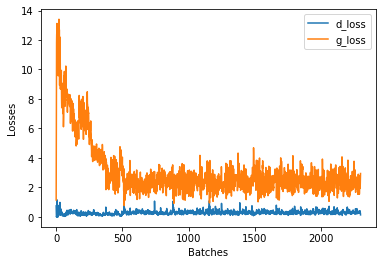

In [12]:
plt.plot(df_fit.index, df_fit['d_loss'], label='d_loss')
plt.plot(df_fit.index, df_fit['g_loss'], label='g_loss')
plt.xlabel('Batches')
plt.ylabel('Losses')
plt.legend()
plt.show()

#### Generate images using models with labels  

In [ ]:
def generate_from_model_digits(batch_size, n_digits, n_noise,
                               model_file=None, height=None):
    if model_file is None:
        generator = generator_model()
        #generator.compile(loss="binary_crossentropy", optimizer="SGD")
        generator.compile(loss="binary_crossentropy", optimizer="Adam")
        generator.load_weights("generator")
    else:
        print('model_file:', model_file)
        generator = load_model(model_file)

    noise = np.zeros((batch_size*n_digits, n_noise))
    labels = np.zeros((batch_size*n_digits, n_digits))
    #print('batch:', batch_size)
    #print('digits:', n_digits)
    for i in range(batch_size):
        noise1 = np.random.uniform(-1, 1, n_noise)
        for d in range(n_digits):
            label1 = to_categorical(d, n_digits)
            #print('label1:', d, label1)
            noise[i*n_digits+d, :] = noise1
            labels[i*n_digits+d:, :] = label1
    #print(noise)
    #print(labels)
    generated_images = generator.predict([noise, labels], verbose=1)
    if height is None:
        height = batchsize
    image = combine_images_digits(generated_images, n_digits,
                                  height=height)
    image = image*127.5+127.5
    png = "generated_image_from_model.png"
    Image.fromarray(image.astype(np.uint8)).save(png)

#### Generate image by using Generator  

In [ ]:
generate_from_model_digits(batch_size, n_digits, n_noise, model_file=model_g, height=16)

model_file: model_cdcgan-b32_g-d48.h5


/home/anhvu/.local/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
